# Step 0: Pre-processing

Base path: set this to a location on your local machine where you'd like the script to output files.

In [1]:
base_path = 'C:/Users/geoffc.REDMOND/OneDrive/Data512/A1/'

# Step 1: Data acquisition

In [2]:
import requests
import json

Define a function to output data to json files.
Input: The function recieves a dict object and meta data to properly name file.
Output: The function writes dict object to json file.

In [3]:
def outputToJson(base_path,apiname,accesstype,start,end,data):
    out_path = base_path + apiname + '_' + accesstype + '_' + start + '-' + end + '.json'
    with open(out_path, 'w') as f:
        json.dump(data, f)

Pull page views through wikimedia API from July 2015 an onward. Output intermediate data to json.

In [4]:
endpoint_views = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

start = '20150701'
end = '20171110'

params_views = {'project' : 'en.wikipedia.org',
            'access' : 'mobile-web',
            'agent' : 'user',
            'granularity' : 'monthly',
          'start' : start+'00',
            'end' : end+'00'
            }

mobile_web_views = requests.get(endpoint_views.format(**params_views))
outputToJson(base_path,'pageviews','mobile-web',start,end,mobile_web_views.json())

params_views['access'] = 'mobile-app'
mobile_app_views = requests.get(endpoint_views.format(**params_views))
outputToJson(base_path,'pageviews','mobile-app',start,end,mobile_app_views.json())

params_views['access'] = 'desktop'
desktop_views = requests.get(endpoint_views.format(**params_views))
outputToJson(base_path,'pageviews','desktop',start,end,desktop_views.json())

Pull page counts through wikimedia pagecounts API from January 2008 through August 2016. Output intermediate data to json.

In [5]:
endpoint_counts = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

start = '20080101'
end = '20171110'

params_count = {'project' : 'en.wikipedia.org',
            'access-site' : 'desktop-site',
            'granularity' : 'monthly',
            'start' : start + '00',
            'end' : end + '00'
            }

desktop_counts = requests.get(endpoint_counts.format(**params_count))
outputToJson(base_path,'pagecounts','desktop',start,end,desktop_counts.json())

params_count['access-site'] = 'mobile-site'
mobile_counts = requests.get(endpoint_counts.format(**params_count))
outputToJson(base_path,'pagecounts','mobile-site',start,end,mobile_counts.json())

# Step 2: Data processing

Put the page view data into a pandas dataframe and join it all together. Standardize the columns.

In [6]:
import pandas as pd
from pandas.io.json import json_normalize

Pull mobile and desktop view data into Pandas DataFrames.

In [7]:
data_mobile_web_views = json_normalize(json.loads(mobile_web_views.text)['items'])
data_mobile_app_views = json_normalize(json.loads(mobile_app_views.text)['items'])
data_desktop_views = json_normalize(json.loads(desktop_views.text)['items'])

Join view data into one DataFrame.

In [8]:
data_views = pd.merge(data_mobile_web_views,data_mobile_app_views,on='timestamp',how='outer')
data_views = pd.merge(data_views,data_desktop_views,on='timestamp',how='outer')

Get rid of extra columns and rename columns in view data.

In [9]:
data_views['pageview_mobile_views'] = data_views['views_x'] + data_views['views_y']
data_views['pageview_all_views'] = data_views['pageview_mobile_views'] + data_views['views']
data_views = data_views.drop(data_views.columns[[0,1,2,3,5,6,7,8,9,10,11,12,13,14]],axis=1)
data_views.columns = ['timestamp','pageview_desktop_views','pageview_mobile_views','pageview_all_views']
#data_views.head(1)

Pull mobile and desktop count data into Pandas DataFrames.

In [10]:
data_desktop_counts = json_normalize(json.loads(desktop_counts.text)['items'])
data_mobile_counts = json_normalize(json.loads(mobile_counts.text)['items'])

Join count data into one DataFrame.

In [11]:
data_counts = pd.merge(data_desktop_counts,data_mobile_counts,on='timestamp',how='outer')
data_counts = data_counts.fillna(0)

Get rid of extra columns and rename columns in count data.

In [12]:
data_counts['pageview_all_views'] = data_counts['count_x'] + data_counts['count_y']
data_counts = data_counts.drop(data_counts.columns[[0,2,3,5,7,8]],axis=1)
data_counts.columns = ['pagecount_desktop_views','timestamp','pagecount_mobile_views','pagecount_all_views']
#data_counts.head(1)

Merge the count and view data together into one dataframe that contains all data. Separate month and year into separate fields. Set correct data types of number of views and timestamp fields.

In [13]:
data = pd.merge(data_counts,data_views,on='timestamp',how='outer')
data['year'] = data['timestamp'].str[:4]
data['month'] = data['timestamp'].str[4:6]
data = data[['timestamp','year','month','pagecount_all_views','pagecount_desktop_views','pagecount_mobile_views','pageview_all_views','pageview_desktop_views','pageview_mobile_views']]
data = data.fillna(0)
data = data.apply(pd.to_numeric)
data.sort_values(['timestamp'],ascending=[True])
data['timestamp'] = pd.to_datetime(data['timestamp'].astype(str).str[0:8],format='%Y%m%d')
#data

Export intermediate data to csv in format specified.

In [14]:
data_step2_output = data.drop(data.columns[[0]],axis=1)

path = base_path + 'en-wikipedia_traffic_200801-201709.csv'
data_step2_output.to_csv(path_or_buf=path,sep=',', encoding='utf-8')

Do some filtering on data to prepare for analysis step. Show views and counts in Millions for visualization purposes.

In [15]:
import datetime
data_step3 = pd.concat([data[['timestamp']]
    ,data[['pagecount_all_views','pagecount_desktop_views','pagecount_mobile_views','pageview_all_views','pageview_desktop_views','pageview_mobile_views']]/(1000*1000)],axis=1)
data_pc = data_step3[(data_step3['timestamp']<datetime.date(2016,8,1))]
data_pv = data_step3[(data_step3['timestamp']>datetime.date(2015,7,1))]

# Step 3: Analysis

In [16]:
import matplotlib.pyplot as plt

Define a function which generates a plot based on data in the previous steps.
Input: Recieves a boolean which indicates if function should show plot in Jupyter notebooks or output a .png to file.

In [17]:
def generatePlot(show=True):
    plt.plot("timestamp","pagecount_all_views",data=data_pc,c='black',linestyle='--')
    plt.plot("timestamp","pagecount_desktop_views",data=data_pc,c='green',linestyle='--')
    plt.plot("timestamp","pagecount_mobile_views",data=data_pc,c='blue',linestyle='--')
    line1, = plt.plot("timestamp","pageview_all_views",data=data_pv,c='black',linestyle='solid',label='total')
    line2, = plt.plot("timestamp","pageview_desktop_views",data=data_pv,c='green',linestyle='solid',label='main site')
    line3, = plt.plot("timestamp","pageview_mobile_views",data=data_pv,c='blue',linestyle='solid',label='mobile site')
    plt.legend(handles=[line1,line2,line3],loc="upper left")
    plt.title('Page Views on English Wikipedia (x 1,000,000)')
    plt.ticklabel_format(style='plain',axis='y')
    plt.xlabel('Year')
    plt.ylabel('Views')
    if show:
        plt.show()
    else:
        path = base_path + 'eng_wikipedia_pageviews.png'
        plt.savefig(path)

Run the generatePlot function to output plot to base_path file location. Run it again and show plot below.

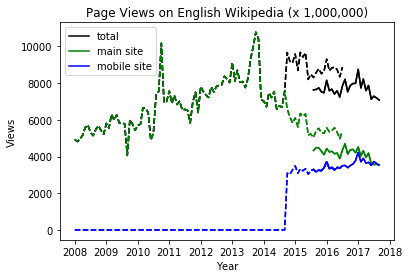

In [18]:
generatePlot(show=False)
generatePlot()